## Introduction

The 116th United States Congress proposes many bills. The conventional wisdom is that few of these get voted on and passed. The purpose of this investigation is to attempt to predict which bills will get passed based solely on an executive summary provided in the dataset. To do this, we will be using the workflow mentioned in chapter 11 of [Deep Learning](http://www.deeplearningbook.org/), a free online textbook by Goodfellow, Bengio, and Courville. The following quote is from pages 416 and 417 of the book.

_We recommend the following practical design process:_

_•Determine your goals—what error metric to use, and your target value forthis error metric. These goals and error metrics should be driven by theproblem that the application is intended to solve._

_•Establish a working end-to-end pipeline as soon as possible, including the estimation of the appropriate performance metrics._

_•Instrument the system well to determine bottlenecks in performance. Diag-nose which components are performing worse than expected and whetherpoor performance is due to overﬁtting, underﬁtting, or a defect in the dataor software._

_•Repeatedly make incremental changes such as gathering new data, adjustinghyperparameters, or changing algorithms, based on speciﬁc ﬁndings fromyour instrumentation._

## Imports and Data

In [1]:
import os, re, string
import xml.etree.ElementTree as etree
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#Example of the Data
tree = etree.parse('../Downloads/congress/data/116/bills/s/s1/data.xml')
root = tree.getroot()
root.find('actions').find('vote').attrib, root.find('summary').text

({'how': 'roll',
  'type': 'vote',
  'roll': '16',
  'datetime': '2019-02-05',
  'where': 's',
  'result': 'pass',
  'state': 'PASS_OVER:SENATE'},
 "Strengthening America's Security in the Middle East Act of 2019\n\nThis bill authorizes assistance and weapons transfers to Israel, extends defense cooperation with Jordan, establishes additional sanctions related to the conflict in Syria, and allows states to divest from entities boycotting Israel.\n\nIleana Ros-Lehtinen United States-Israel Security Assistance Authorization Act of 2019\n\nThe bill reauthorizes through\xa0FY2028 Foreign Military Financing to Israel. It extends loan guarantees to Israel through FY2023 and authorizes the President to transfer precision-guided munitions to the country.\n\nThe bill\xa0directs the President to report on steps taken to help Israel secure a strategic trade authorization exception.\n\nThe bill directs the National Aeronautics and Space Administration to continue working with the Israel Space Agen

To get access to this free dataset and see more details about it check out [this site](https://www.propublica.org/datastore/dataset/congressional-data-bulk-legislation-bills).

## Performance Metrics

As we will see in the next section, around 95% of bills do not pass. Additionally, we will find that only bills that are sure to pass get voted on because every voted on bill passed.

Taking this into account, we forego making the overall objective accuracy. Instead, we will measure performance by taking the area under the ROC curve. This has an effective minimum of approximately .5 (with random guessing) and a maximum of 1. Based on the outcome of several simple models, we will aim for a score of .8. This would mean that the probability is .8 that a given bill that is passed has a higher score on the model than a given bill that is not passed. For more information, see [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

## Baseline Approach

The basic strategy here is to use Latent Semantic Analysis on a count vectorization of the data. Then, we run a basic logistic regression on the output. Comments will be sprinkled in at appropriate places to highlight observations about the data/problem.

In [3]:
from sklearn.feature_extraction import text as txt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier

In [4]:
#Data Input and Cleaning
def gather_data_bill_pass(n):
    try:
        tree = etree.parse('../Downloads/congress/data/116/bills/s/s{}/data.xml'.format(n))
        root = tree.getroot()
        text = root.find('summary').text
        result = root.find('actions').find('vote').attrib['result']
        return result
    except:
        pass
    
set([gather_data_bill_pass(i) for i in range(1,4212)])

{None, 'pass'}

This is here to demontrate that every bill that has a _vote_ action has a _pass_ action. So, we only pay attention to which bills were voted on.

In [5]:
def gather_data_bill_voted(n):
    try:
        tree = etree.parse('../Downloads/congress/data/116/bills/s/s{}/data.xml'.format(n))
        root = tree.getroot()
        text = root.find('summary').text
        result = "pass" if root.find('actions').find('vote') else None
        return result, text
    except:
        pass
    
data_in = [gather_data_bill_voted(i) for i in range(1,4212)]
data_in = [i for i in data_in if i is not None] #Some bills have no summaries. These are skipped.

In [6]:
def data_cleaning(s_in):
    s = ' '.join(s_in.split()) #remove nonspace whitespace characters
    s = s.replace('-',' ') #replace dashes
    s = re.compile('[%s]' % re.escape(string.punctuation)).sub('',s).lower() #remove punctuation
    return s

data = [[i[0],data_cleaning(i[1])] for i in data_in]

In [7]:
corpus = [i[1] for i in data]
target = [i[0]=='pass' for i in data] #1 for pass, 0 for no pass (and not voted)
print('Rounded proportion of bills that were passed:',round(np.mean(target),3))

Rounded proportion of bills that were passed: 0.054


In [8]:
#Data Transformation
def latent_semantic_analysis(corp):
    vectorizer = txt.CountVectorizer(stop_words='english')
    X_orig = vectorizer.fit_transform(corpus)
    svd = TruncatedSVD(100)
    X = svd.fit_transform(X_orig)
    return X

X = latent_semantic_analysis(corpus)

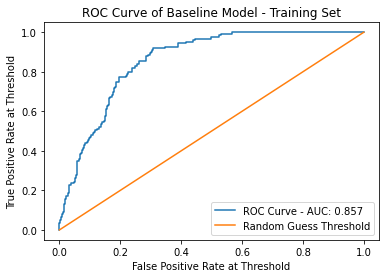

In [9]:
#Baseline Model - Single Test
t = int(.8*len(target)) #Train on first 80% of records

model = LogisticRegression(class_weight='balanced')
model.fit(X[:t],target[:t])
back_preds = model.predict_proba(X[:t])[:,1]

xs, ys, _ = metrics.roc_curve(target[:t],back_preds)
plt.plot(xs,ys,label = 'ROC Curve - AUC: {}'.format(round(metrics.roc_auc_score(target[:t],back_preds),3)))
plt.plot([0,1],[0,1],label = 'Random Guess Threshold')
plt.xlabel('False Positive Rate at Threshold')
plt.ylabel('True Positive Rate at Threshold')
plt.title('ROC Curve of Baseline Model - Training Set')
plt.legend()
plt.show()

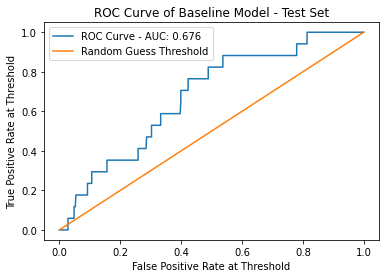

In [10]:
preds = model.predict_proba(X[t:])[:,1]

xs, ys, _ = metrics.roc_curve(target[t:],preds)
plt.plot(xs,ys,label = 'ROC Curve - AUC: {}'.format(round(metrics.roc_auc_score(target[t:],preds),3)))
plt.plot([0,1],[0,1],label = 'Random Guess Threshold')
plt.xlabel('False Positive Rate at Threshold')
plt.ylabel('True Positive Rate at Threshold')
plt.title('ROC Curve of Baseline Model - Test Set')
plt.legend()
plt.show()

In [11]:
#Baseline Model - Cross Validated
kf = KFold()
interp_score = 0
extrap_score = 0

for train_ind, test_ind in kf.split(X):
    train, labels = X[train_ind], np.array(target)[train_ind]
    test, answers = X[test_ind], np.array(target)[test_ind]
    
    model = LogisticRegression(class_weight='balanced')
    model.fit(train,labels)
    
    interp_preds = model.predict_proba(train)[:,1]
    extrap_preds = model.predict_proba(test)[:,1]
    
    interp_score += metrics.roc_auc_score(labels,interp_preds)/5
    extrap_score += metrics.roc_auc_score(answers,extrap_preds)/5
    
print('5-Fold Training AUC Score:', interp_score,'\n5-Fold Testing AUC Score: ', extrap_score)

5-Fold Training AUC Score: 0.861901637859771 
5-Fold Testing AUC Score:  0.6830881378934432


## More Sophisticated Model Attempts with Summaries

### Attempt 1: Random Forest with CountVec or Tf-idf

In [12]:
#Data Transformation
def latent_semantic_analysis_tfidf(corp):
    vectorizer = txt.TfidfVectorizer(stop_words='english')
    X_orig = vectorizer.fit_transform(corp)
    svd = TruncatedSVD(100)
    X = svd.fit_transform(X_orig)
    return X

X_tfidf = latent_semantic_analysis_tfidf(corpus)

In [13]:
#Count Vectorizer with Random Forest
kf = KFold()
interp_score = 0
extrap_score = 0

for train_ind, test_ind in kf.split(X):
    train, labels = X[train_ind], np.array(target)[train_ind]
    test, answers = X[test_ind], np.array(target)[test_ind]
    
    model = RandomForestClassifier(1000, class_weight='balanced', n_jobs = -1)
    model.fit(train,labels)
    
    interp_preds = model.predict_proba(train)[:,1]
    extrap_preds = model.predict_proba(test)[:,1]
    
    interp_score += metrics.roc_auc_score(labels,interp_preds)/5
    extrap_score += metrics.roc_auc_score(answers,extrap_preds)/5
    
print('5-Fold Training AUC Score:', interp_score,'\n5-Fold Testing AUC Score: ', extrap_score)

5-Fold Training AUC Score: 0.9999566576386762 
5-Fold Testing AUC Score:  0.6760280632031386


In [14]:
#Tf-idf with Random Forest
kf = KFold()
interp_score = 0
extrap_score = 0

for train_ind, test_ind in kf.split(X_tfidf):
    train, labels = X_tfidf[train_ind], np.array(target)[train_ind]
    test, answers = X_tfidf[test_ind], np.array(target)[test_ind]
    
    model = RandomForestClassifier(1000, class_weight='balanced', n_jobs=-1)
    model.fit(train,labels)
    
    interp_preds = model.predict_proba(train)[:,1]
    extrap_preds = model.predict_proba(test)[:,1]
    
    interp_score += metrics.roc_auc_score(labels,interp_preds)/5
    extrap_score += metrics.roc_auc_score(answers,extrap_preds)/5
    
print('5-Fold Training AUC Score:', interp_score,'\n5-Fold Testing AUC Score: ', extrap_score)

5-Fold Training AUC Score: 0.9999650822614068 
5-Fold Testing AUC Score:  0.7032740408067233


We can see that the training set score is very high, so we are certainly not underfitting. Let's check to see if adding more training data would help.

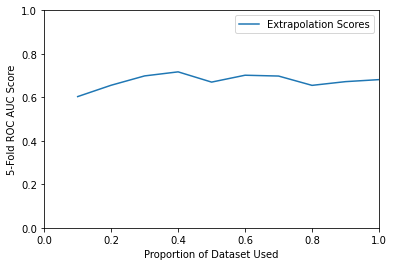

In [15]:
ex_scores = []
l = len(corpus)

for p in range(1,11):
    X_tfidf = latent_semantic_analysis_tfidf(corpus[:int(.1*p*l)])
    target_l = target[:int(.1*p*l)]
    kf = KFold()
    extrap_score = 0

    for train_ind, test_ind in kf.split(X_tfidf):
        train, labels = X_tfidf[train_ind], np.array(target_l)[train_ind]
        test, answers = X_tfidf[test_ind], np.array(target_l)[test_ind]

        model = RandomForestClassifier(100, class_weight='balanced', n_jobs=-1)
        model.fit(train,labels)

        extrap_preds = model.predict_proba(test)[:,1]
        extrap_score += metrics.roc_auc_score(answers,extrap_preds)/5
    
    ex_scores.append(extrap_score)
        
plt.plot(np.linspace(.1,1,10), ex_scores, label='Extrapolation Scores')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('5-Fold ROC AUC Score')
plt.xlabel('Proportion of Dataset Used')
plt.show()

The AUC score is basically flat after using more than 30% of the dataset, so it does not seem like we need more data (yet). Let's check the worst guesses of the model to see if there is any more information for us there.

#### Worst Guesses

In [16]:
worst_5_up = np.argsort(extrap_preds - answers)[:5] #Passed but not predicted
worst_5_down = np.argsort(extrap_preds - answers)[-5:] #Not passed, but should have

In [17]:
[corpus[test_ind[i]] for i in worst_5_up]

['covid 19 pandemic moment of silence act this bill directs the president to issue a proclamation calling on the people of the united states to observe a moment of silence on june 1 2020 to honor the memory of the lives lost in the united states due to the covid 19 ie coronavirus disease 2019 pandemic',
 'major medical facility authorization act of 2020 this bill authorizes the department of veterans affairs to carry out specified major medical facility projects during fy2020 the bill also indicates the maximum amount that can be spent on each project',
 'this bill releases certain reversionary interest in land to tennessee and adds additional lands to the rough mountain wilderness and the rich hole wilderness in virginia sec 1 upon the transfer of ownership of the approximately 090 acre parcel of land identified as the webb property to tennessee for inclusion in the chickasaw state forest and the transfer of the approximately 062 acre parcel of land identified as state forest land to 

In [18]:
[corpus[test_ind[i]] for i in worst_5_down]

['designates the facility of the united states postal service located at 2600 wesley street in greenville texas as the audie murphy post office building',
 'designates the facility of the united states postal service located at 171 south maple street in dana indiana as the ernest ernie t pyle post office',
 'designates the facility of the united states postal service located at 100 crosby street in mansfield louisiana as the dr co simpkins sr post office',
 'designates the facility of the united states postal service located at 909 west holiday drive in fate texas as the ralph hall post office',
 'designates the facility of the united states postal service located at 311 west wisconsin avenue in tomahawk wisconsin as the einar sarge h ingman jr post office building']

Many of the biggest mistakes are to do with post office renamings. Apart from not being the most substantial bills, these also seem to usually pass. Maybe because we are using the current session of congress, some bills that will eventually get passed are not marked as passed in the data. What happen if we use the data from previous sessions of congress?

### Attempt 2: Redo with More (Older) Data

In the second (and most successful) attempt, we make 116th congress the test set and use the data from the previous three congresses (113, 114, and 115) to train.

Essentially, all the code of the above attempt is put in the following cell and we get out 5 different results.

- The ROC Curve of the Logistic Model on the training set (Graph)
- The ROC Curve of the Logistic Model on the test set (Graph)
- The performance of the random forest using the count vectorizer embedding (2 Printed Lines)
- The performance of the random forest using the tf-idf embedding (2 Printed Lines)
- The performance of the random forest using the tf-idf embedding as a function of the proportion of training data used (Graph; Note that when x% of the training set was used, we use the most recent x%)

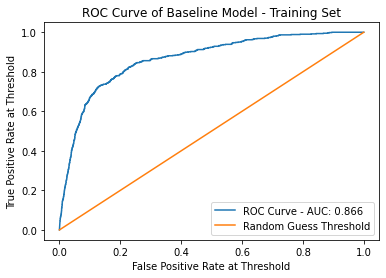

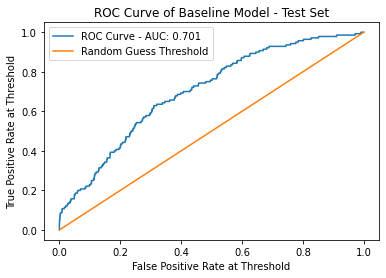

CountVectorizer Training AUC Score: 0.9999994918346294 
CountVectorizer Testing AUC Score:  0.7628290052171873
Tf-idf Training AUC Score: 0.9999991530577158 
Tf-idf Testing AUC Score:  0.7888489946655725


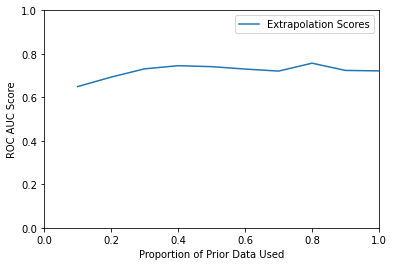

In [19]:
def gather_data_bill_voted(n):
    try:
        tree = etree.parse('../Downloads/congress/data/{}/bills/s/s{}/data.xml'.format(cong_num,n))
        root = tree.getroot()
        text = root.find('summary').text
        result = "pass" if root.find('actions').find('vote') else None
        if (cong_num == 113) and (n == 2280):
            result = None
        return result, text
    except:
        pass

cong_num = 113
data_in_113 = [gather_data_bill_voted(i) for i in range(1,20000)]
cong_num = 114    
data_in_114 = [gather_data_bill_voted(i) for i in range(1,20000)]
cong_num = 115
data_in_115 = [gather_data_bill_voted(i) for i in range(1,20000)]
cong_num = 116
data_in_116 = [gather_data_bill_voted(i) for i in range(1,20000)]
data_in = data_in_113 + data_in_114 + data_in_115 + data_in_116

len_116 = len([i for i in data_in_116 if i is not None])

data_in = [i for i in data_in if i is not None] #Some bills have no summaries. These are skipped.

data = [[i[0],data_cleaning(i[1])] for i in data_in]

corpus = [i[1] for i in data]
target = [i[0]=='pass' for i in data] #1 for pass, 0 for no pass (and not voted)

X = latent_semantic_analysis(corpus)
X_tfidf = latent_semantic_analysis_tfidf(corpus)

train, test = X[:-len_116], X[-len_116:]
train_tf, test_tf = X_tfidf[:-len_116], X_tfidf[-len_116:]
labels, answers = target[:-len_116], target[-len_116:]

#Baseline Model - Single Test
model = LogisticRegression(class_weight='balanced')
model.fit(train,labels)
back_preds = model.predict_proba(train)[:,1]

xs, ys, _ = metrics.roc_curve(labels,back_preds)
plt.plot(xs,ys,label = 'ROC Curve - AUC: {}'.format(round(metrics.roc_auc_score(labels,back_preds),3)))
plt.plot([0,1],[0,1],label = 'Random Guess Threshold')
plt.xlabel('False Positive Rate at Threshold')
plt.ylabel('True Positive Rate at Threshold')
plt.title('ROC Curve of Baseline Model - Training Set')
plt.legend()
plt.show()

preds = model.predict_proba(test)[:,1]

xs, ys, _ = metrics.roc_curve(answers,preds)
plt.plot(xs,ys,label = 'ROC Curve - AUC: {}'.format(round(metrics.roc_auc_score(answers,preds),3)))
plt.plot([0,1],[0,1],label = 'Random Guess Threshold')
plt.xlabel('False Positive Rate at Threshold')
plt.ylabel('True Positive Rate at Threshold')
plt.title('ROC Curve of Baseline Model - Test Set')
plt.legend()
plt.show()
    
model = RandomForestClassifier(1000, class_weight='balanced', n_jobs = -1)
model.fit(train,labels)

interp_preds = model.predict_proba(train)[:,1]
extrap_preds = model.predict_proba(test)[:,1]

interp_score = metrics.roc_auc_score(labels,interp_preds)
extrap_score = metrics.roc_auc_score(answers,extrap_preds)
    
print('CountVectorizer Training AUC Score:', interp_score,
      '\nCountVectorizer Testing AUC Score: ', extrap_score)
    
model = RandomForestClassifier(1000, class_weight='balanced', n_jobs=-1)
model.fit(train_tf,labels)

interp_preds = model.predict_proba(train_tf)[:,1]
extrap_preds = model.predict_proba(test_tf)[:,1]

interp_score = metrics.roc_auc_score(labels,interp_preds)
extrap_score = metrics.roc_auc_score(answers,extrap_preds)
    
print('Tf-idf Training AUC Score:', interp_score,
      '\nTf-idf Testing AUC Score: ', extrap_score)

ex_scores = []
l = len(corpus) - len_116

for p in range(1,11):
    X_p = X_tfidf[l-int(.1*p*l):l]
    target_p = target[l-int(.1*p*l):l]

    model = RandomForestClassifier(100, class_weight='balanced', n_jobs=-1)
    model.fit(X_p,target_p)

    extrap_preds = model.predict_proba(test_tf)[:,1]
    extrap_score = metrics.roc_auc_score(answers,extrap_preds)
    
    ex_scores.append(extrap_score)
        
plt.plot(np.linspace(.1,1,10), ex_scores, label='Extrapolation Scores')
plt.legend()
plt.xlim(0,1)
plt.ylim(0,1)
plt.ylabel('ROC AUC Score')
plt.xlabel('Proportion of Prior Data Used')
plt.show()

# Conclusion

From these results, we can conclude that using the data on prior congresses was _very_ helpful! In fact, if we update our data to not include any bills that should pass in the near future (looking at you, post office renamings), we might get right around our goal of .8 ROC AUC score. That is great!

There are still more informational embeddings and autencoders, as well as a plethora of strong machine learning models that we have not used here. We have hardly even scratched the surface. That is kind of the point though. Every technique we used is fully interpretable and not too complicated in the scheme of things. This goes to show that _good performance can be achieved by white/gray box models_. It was improving the quality of the data that got us our better performance.

Complex and black box models do have their place, though. I am sure that with the improved data quality, well-regularized black box models would still outpreform our models here.

There are two ways to proceed at this. Begin interpretting the process of this model or jump to black box models to improve the score. What one chooses to do depends on the context of the problem at hand.